In [ ]:
# Классификация изображений. Часть 1.

## Свёрточные нейронные сети. Классификация изображений


## Практика. Простой свёрточный слой

В данной практике мы посмотрим, как в Keras настроить свёрточную сеть, а точнее — как добавить свёрточный слой в нашу сеть.
Мы будем использовать Fashion MNIST.

> Fashion MNIST содержит 70 000 изображений элементов одежды в 10 категориях в градациях серого.

### Свертки в Keras

In [ ]:
!pip install -q tensorflow

In [ ]:
import numpy as np  # Импорт библиотеки для работы с массивами и векторной алгеброй
from sklearn.metrics import accuracy_score  # Импорт функции для оценки точности модели
from matplotlib import pyplot as plt  # Импорт библиотеки для визуализации данных

# Настройка для отображения графиков непосредственно в блокноте (например, в Jupyter)
%matplotlib inline

import tensorflow as tf  # Импорт библиотеки TensorFlow для создания и обучения нейронных сетей
print("We're using TF", tf.__version__)  # Вывод версии TensorFlow
import tensorflow.keras as keras  # Импорт высокоуровневого API Keras для TensorFlow
import tensorflow.keras.models as M  # Импорт функционала для создания моделей в Keras
import tensorflow.keras.layers as L  # Импорт слоев для нейронных сетей в Keras
import tensorflow.keras.backend as K  # Импорт функций для низкоуровневой работы с тензорами и графами в Keras
import pandas as pd  # Импорт библиотеки для работы с данными в табличном виде (DataFrame)

We're using TF 2.17.0


### Загрузим данные

Классы:
```
0 T-shirt/top
1 Trouser
2 Pullover
3 Dress
4 Coat
5 Sandal
6 Shirt
7 Sneaker
8 Bag
9 Ankle boot
```


In [ ]:
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
print(x_train.shape)
print(x_val.shape)
print (y_train[:10])
print (y_val[:10])

(60000, 28, 28)
(10000, 28, 28)
[9 0 0 3 0 2 7 2 5 5]
[9 2 1 1 6 1 4 6 5 7]


Пример кусочка картинки:


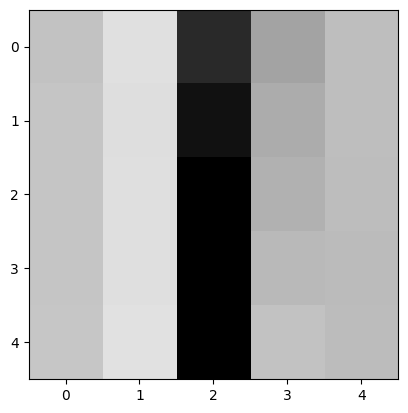

Пример картинки:


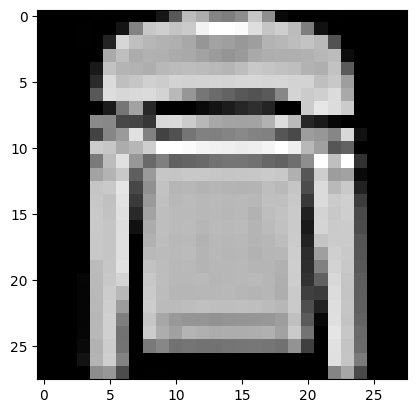

y_train [shape (60000,)] 10 примеров:
 [9 0 0 3 0 2 7 2 5 5]


In [ ]:
# Преобразование изображения для дальнейшей визуализации
# Берем 5-е изображение из набора x_train, изменяем форму и дублируем по 3-му каналу, чтобы создать изображение с 3 каналами (RGB)
x_train_image = np.tile(x_train[5, :, :].reshape((28, 28))[:, :, np.newaxis], (1, 1, 3))

# Вывод примера части изображения
print("Пример кусочка картинки:")
plt.imshow(x_train_image[15:20, 5:10], cmap="Greys")  # Отображение небольшого фрагмента изображения (с 15 по 20 строку и с 5 по 10 столбец)
plt.show()  # Показать фрагмент изображения

# Вывод всего изображения
print("Пример картинки:")
plt.imshow(x_train_image, cmap="Greys")  # Отображение всего изображения с использованием цветовой карты "Greys" для оттенков серого
plt.show()  # Показать полное изображение

# Вывод первых 10 значений из y_train и информации о форме массива y_train
print("y_train [shape %s] 10 примеров:\n" % (str(y_train.shape)), y_train[:10])  # Печать формы массива y_train и первых 10 меток (классов) для изображений

In [ ]:
# Применение one-hot кодирования к меткам классов для y_train и y_val
# Преобразуем метки в формат one-hot, где для каждого класса создается бинарный вектор длины 10
y_train_oh = keras.utils.to_categorical(y_train, 10)  # Применение one-hot кодирования к обучающим меткам
y_val_oh = keras.utils.to_categorical(y_val, 10)      # Применение one-hot кодирования к валидационным меткам

# Вывод информации о форме массива one-hot закодированных меток y_train
print(y_train_oh.shape)  # Печать формы массива y_train_oh

# Вывод первых 5 примеров закодированных меток и соответствующих исходных меток
print(y_train_oh[:5], y_train[:5])  # Печать первых 5 one-hot меток и первых 5 исходных меток

(60000, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] [9 0 0 3 0]


### Собираем модель

Будем минимизировать кросс-энтропию.

In [ ]:
# Очистка текущего графа и освобождение ресурсов TensorFlow/Keras
K.clear_session()

# Создание новой модели с использованием изображения как входа (без вытягивания в вектор)
model = M.Sequential()  # Определяем модель как последовательную (слои будут добавляться последовательно)

# Добавление сверточного слоя (Conv2D) с 1 фильтром 3x3, шагом 1 и сохранением размерности (padding='same')
# Входной слой принимает изображение размером 28x28 с одним каналом (черно-белое изображение)
model.add(L.Conv2D(1, kernel_size=3, strides=1, padding='same', input_shape=(28, 28, 1)))

# Преобразование многомерного тензора в одномерный вектор перед плотным слоем
model.add(L.Flatten())

# Добавление полносвязного (Dense) слоя с 10 нейронами и функцией активации softmax для классификации на 10 классов
model.add(L.Dense(10, activation='softmax'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Вывод краткого описания модели
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 1)           │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │           7,850 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,860 (30.70 KB)

 Trainable params: 7,860 (30.70 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    loss='categorical_crossentropy',  # минимизируем кросс-энтропию
    optimizer='adam',  # так будет быстрее, позже узнаем что это
    metrics=['accuracy']  # выводим процент правильных ответов
)

In [ ]:
# центрируем и нормируем, так сети будет проще учиться (позже узнаем почему :)
x_train_float = x_train.astype(float) / 255 - 0.5
x_val_float = x_val.astype(float) / 255 - 0.5

In [ ]:
# Обучение модели на тренировочных данных
model.fit(
    x_train_float[:, :, :, np.newaxis],  # Тренировочные данные. Добавляем дополнительное измерение (канал) для соответствия входному формату (28x28x1).
    y_train_oh,  # One-hot закодированные метки классов для тренировочных данных.
    batch_size=32,  # Размер мини-выборки (batch size). Модель обновляет свои параметры после каждого мини-пакета из 32 изображений.
    epochs=5,  # Количество эпох — полный цикл обучения на всех тренировочных данных. Модель обучится за 5 эпох.
    validation_data=(x_val_float[:, :, :, np.newaxis], y_val_oh)  # Валидационные данные, на которых модель будет проверяться после каждой эпохи.
)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7430 - loss: 0.7610 - val_accuracy: 0.8264 - val_loss: 0.4927
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8408 - loss: 0.4570 - val_accuracy: 0.8358 - val_loss: 0.4726
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8477 - loss: 0.4341 - val_accuracy: 0.8374 - val_loss: 0.4641
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8529 - loss: 0.4195 - val_accuracy: 0.8378 - val_loss: 0.4573
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8543 - loss: 0.4149 - val_accuracy: 0.8387 - val_loss: 0.4505


#### Усложняем свёрточный слой

Теперь мы готовы усложнить свёрточный слой и применить его к какой-нибудь цветной картинке.


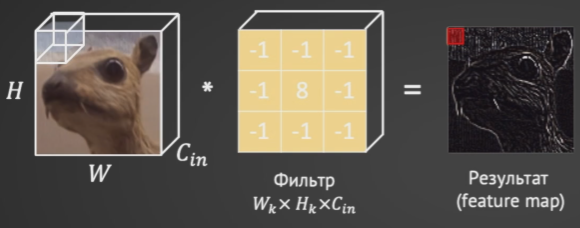

Картинку будем описывать тензором размера W х H х Сin , где Сin  — количество входных каналов (три канала RGB).

Для операции свёртки будем теперь «вырезать» не квадратик, как раньше, а кубик, чтобы отличать, например, рыжих котов от чёрных. Фильтр теперь тоже тензор, и его глубина также равна Сin.

Независимо от того, какой размерности у нас картинка и фильтр, на выходе всё равно будет скаляр, так как мы берём входной кусочек объёма и объёмный фильтр, перемножаем и складываем, получая скаляр. То есть, применив свёртку к картинке, получим плоскую картинку.

Мы потеряли достаточно много информации, ведь на вход подавалась трёхмерная картинка, а на выходе получилась двумерная.  Тут-то и становится понятно, что одного фильтра мало.

#### Как решить эту проблему?

Мы можем обучить много разных фильтров, все их применить, а результирующие картинки соединить в одну объёмную картинку на выходе. Каждый разрез этой объёмной выходной картинки будет хранить некую карту фичей, которую мы насчитаем.

Допустим, зелёный фильтр на картинке будет определять пиксели на горизонтальной границе, то есть всегда, когда мы будем на горизонтальной границе изображения, этот нейрон будет принимать какое-то большое значение.

Красный же фильтр научим определять пиксели на границе объекта по диагонали. И теперь в одном пикселе входного изображения появляется целый вектор признаков, которые мы можем использовать для дальнейшего анализа. Этих признаков мы можем сделать сколько угодно. Это наш гиперпараметр Сout  — количество выходных каналов в нашем объёме. Очевидно, что Сout  > 1, а на практике может быть такое значение как 32 или 64.



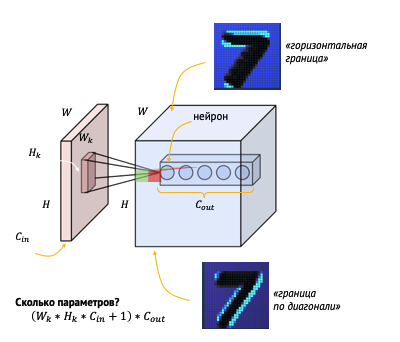

Теперь у пикселя появляется глубина, и мы переходим в новые координаты. Исходные координаты RGB были неудобны, так как в них ничего непонятно было о картинке, а теперь мы можем перейти, например, в 32 признака, каждый из которых решает свою определённую подзадачу. Мы сможем понять, на какой части картинки мы изображены: на горизонтальной или на диагональной.

Следующие фильтры, которые будут применяться, смогут учитывать все эти признаки одновременно и научатся решать более сложную задачу.

Вновь подчеркнём, как мало параметров мы использовали. Если наш фильтр имеет размеры Wk х Hk х Сin , то для того чтобы научить Сout таких фильтров, необходимо всего лишь ( Wk * Hk * Сin + 1 ) * Сout параметров.

#### Да, и одного свёрточного слоя мало!

Допустим, на картинке 300 × 300 изображён кот, а наш первый свёрточный слой посмотрел на кусочки изображения 3 × 3. Эти кусочки слишком маленькие, мы не можем из них собрать кота.

Давайте посмотрим, что произойдёт с нашей картинкой и преобразованиями в нейросети, когда мы к первому результату нашей свёртки применим ещё один свёрточный слой.

На примере ниже — вход размера 5 × 5. Мы применили свёртку размера 3 × 3 и получили девять различных значений. Заметьте, что на первом свёрточном слое каждый нейрон (например, зелёный, выделенный на картинке) смотрит на кусочек изображения размером 3 × 3. Но если к результату первого свёрточного слоя ещё раз применить свёртку с какими-то другими значениями в фильтре того же размера 3 × 3, то любой нейрон на выходе второго слоя свёртки уже смотрит эффективно на кусочек картинки размером 5 × 5, так как все нейроны, с которыми слой работает, смотрят на целый кусочек размера 3 × 3. Если провести пунктирные линии, то видно, что у нашего нейрона «повысилось поле обзора», и он смотрит на больший кусочек изображения. То есть, создавая больше слоёв, мы имеем возможность определить котика всё большего и большего размера.

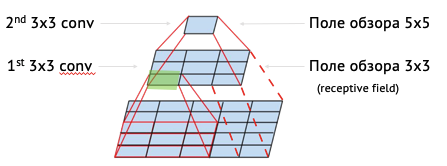

#### Вопросы:
1. Зачем использовать несколько фильтров?
2. Зачем использовать несколько сверточных слоев?

#### Что делать, если у нас котик занимает весь размер картинки (300 × 300)?

Посчитаем, сколько нам потребуется слоёв, чтобы распознать такого котика.

Рассмотрим это на простом одномерном примере. Допустим, у нас на входе одномерный вектор из девяти нейронов. Посмотрим, как будет выглядеть результат первой свёртки размером 3 × 1.

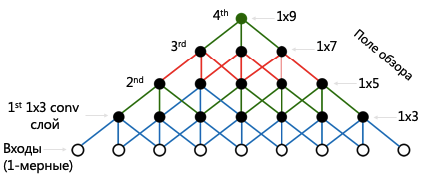

Каждый нейрон на первом свёрточном слое смотрит на три нейрона нашего изображения. Если мы применим ещё один свёрточный слой, то нейроны второго слоя будут смотреть уже на пять пикселей нашего изображения. Если так продолжать делать, то можно вывести формулу. Видно, что наше поле обзора прирастает линейно по количеству слоёв. Значит, чтобы посмотреть на котика размером 300 × 300, нам понадобится 150 слоёв, а это очень много. Возникает проблема, потому что столько слоёв будут очень долго просчитываться.

### Практика. Усложняем свёрточный слой

### Свертки в Keras

In [ ]:
!pip install -q tensorflow

In [ ]:
import numpy as np  # Импорт библиотеки для работы с массивами и векторной алгеброй
from sklearn.metrics import accuracy_score  # Импорт функции для оценки точности модели
from matplotlib import pyplot as plt  # Импорт библиотеки для визуализации данных

# Настройка для отображения графиков непосредственно в блокноте (например, в Jupyter)
%matplotlib inline

import tensorflow as tf  # Импорт библиотеки TensorFlow для создания и обучения нейронных сетей
print("We're using TF", tf.__version__)  # Вывод версии TensorFlow
import tensorflow.keras as keras  # Импорт высокоуровневого API Keras для TensorFlow
import tensorflow.keras.models as M  # Импорт функционала для создания моделей в Keras
import tensorflow.keras.layers as L  # Импорт слоев для нейронных сетей в Keras
import tensorflow.keras.backend as K  # Импорт функций для низкоуровневой работы с тензорами и графами в Keras
import pandas as pd  # Импорт библиотеки для работы с данными в табличном виде (DataFrame)

We're using TF 2.17.0


### Загрузим данные

Классы:
```
0 T-shirt/top
1 Trouser
2 Pullover
3 Dress
4 Coat
5 Sandal
6 Shirt
7 Sneaker
8 Bag
9 Ankle boot
```


In [ ]:
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.fashion_mnist.load_data()

In [ ]:
print(x_train.shape)
print(x_val.shape)
print (y_train[:10])
print (y_val[:10])

(60000, 28, 28)
(10000, 28, 28)
[9 0 0 3 0 2 7 2 5 5]
[9 2 1 1 6 1 4 6 5 7]


Пример кусочка картинки:


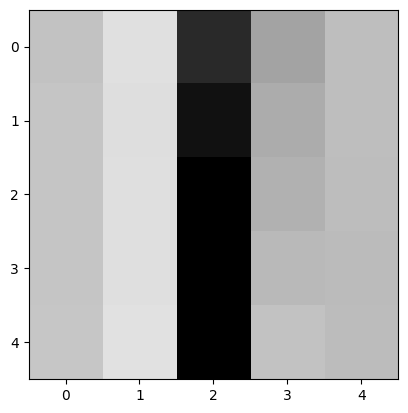

Пример картинки:


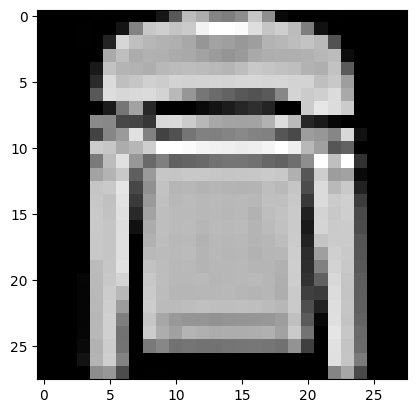

y_train [shape (60000,)] 10 примеров:
 [9 0 0 3 0 2 7 2 5 5]


In [ ]:
# Преобразование изображения для дальнейшей визуализации
# Берем 5-е изображение из набора x_train, изменяем форму и дублируем по 3-му каналу, чтобы создать изображение с 3 каналами (RGB)
x_train_image = np.tile(x_train[5, :, :].reshape((28, 28))[:, :, np.newaxis], (1, 1, 3))

# Вывод примера части изображения
print("Пример кусочка картинки:")
plt.imshow(x_train_image[15:20, 5:10], cmap="Greys")  # Отображение небольшого фрагмента изображения (с 15 по 20 строку и с 5 по 10 столбец)
plt.show()  # Показать фрагмент изображения

# Вывод всего изображения
print("Пример картинки:")
plt.imshow(x_train_image, cmap="Greys")  # Отображение всего изображения с использованием цветовой карты "Greys" для оттенков серого
plt.show()  # Показать полное изображение

# Вывод первых 10 значений из y_train и информации о форме массива y_train
print("y_train [shape %s] 10 примеров:\n" % (str(y_train.shape)), y_train[:10])  # Печать формы массива y_train и первых 10 меток (классов) для изображений

In [ ]:
# Применение one-hot кодирования к меткам классов для y_train и y_val
# Преобразуем метки в формат one-hot, где для каждого класса создается бинарный вектор длины 10
y_train_oh = keras.utils.to_categorical(y_train, 10)  # Применение one-hot кодирования к обучающим меткам
y_val_oh = keras.utils.to_categorical(y_val, 10)      # Применение one-hot кодирования к валидационным меткам

# Вывод информации о форме массива one-hot закодированных меток y_train
print(y_train_oh.shape)  # Печать формы массива y_train_oh

# Вывод первых 5 примеров закодированных меток и соответствующих исходных меток
print(y_train_oh[:5], y_train[:5])  # Печать первых 5 one-hot меток и первых 5 исходных меток

(60000, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] [9 0 0 3 0]


### Собираем модель

Будем минимизировать кросс-энтропию.

Теперь мы знаем, что сверточный слой должен быть не один, в нем должно быть больше фильтров, так как если в сверточном слое мы считаем всего один фильтр, мы теряем информацию.

Предположим у нас была цветная картинка, но, применив один фильтр, мы сжали ее до картинки с одним каналом, то есть до чего-то одномерного, хотя на фходе картинка была трехмерной.

Все признаки пикселей мы можем закодировать в глубине, которую даёт нам свёртка.

Используя один слой и один канал на входе и на выходе, мы получали на выходе следующий объём: (None, 28, 28, 1)  

Попробуем обучить десять фильтров:

In [ ]:
# Очистка текущего графа и освобождение ресурсов TensorFlow/Keras
K.clear_session()

# Создание новой модели с использованием изображения как входа (без вытягивания в вектор)
model = M.Sequential()  # Определяем модель как последовательную (слои будут добавляться последовательно)

# Добавление сверточного слоя (Conv2D) с 10 фильтрами 3x3, шагом 1 и сохранением размерности (padding='same')
# Входной слой принимает изображение размером 28x28 с одним каналом (черно-белое изображение)
model.add(L.Conv2D(filters=10, kernel_size=3, strides=1, padding='same', input_shape=(28, 28, 1)))

In [ ]:
# Вывод краткого описания модели
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 10)          │             100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 100 (400.00 B)

 Trainable params: 100 (400.00 B)

 Non-trainable params: 0 (0.00 B)

Заметим, что на выходе теперь десять каналов: (None, 28, 28, 10). Это обусловлено тем, что в каждом пикселе появилась глубина. Количество параметров = 100, по десять параметров на каждый фильтр. Соответственно, если у нас 32 фильтра, то получим 320 параметров.

Мы знаем, что одного свёрточного слоя мало, потому что сейчас каждый из нейронов смотрит на кусочек картинки 3 × 3, что объективно мало. Добавим ещё **один свёрточный слой:**

In [ ]:
# Очистка текущего графа и освобождение ресурсов TensorFlow/Keras
K.clear_session()

# Создание новой модели с использованием изображения как входа (без вытягивания в вектор)
model = M.Sequential()  # Определяем модель как последовательную (слои будут добавляться последовательно)

model.add(L.Conv2D(filters=32, kernel_size=3, strides=1, padding='same', input_shape=(28, 28, 1)))
model.add(L.Conv2D(filters=32, kernel_size=3, strides=1, padding='same'))

# Вывод краткого описания модели
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 32)          │           9,248 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,568 (37.38 KB)

 Trainable params: 9,568 (37.38 KB)

 Non-trainable params: 0 (0.00 B)

Во втором свёрточном слое получим уже 9 248 параметров! Откуда такое число? Давайте разберёмся.

Второй слой будет сворачивать все каналы входного для него изображения, работая с выходом из первого свёрточного слоя, то есть Keras будет вырезать кусочки размера 3 × 3 × 32. Таким образом, для одного фильтра потребуется 3 × 3 × 32 + 1 параметров. Всего на 32 фильтра: (3 × 3 × 32 + 1) * 32 =9 248.

Можно продолжать добавлять свёрточные слои, увеличивая количество каналов в них. Тогда слои будут использовать всё больше и больше параметров.

In [ ]:
# Очистка текущего графа и освобождение ресурсов TensorFlow/Keras
K.clear_session()

# Создание новой модели с использованием изображения как входа (без вытягивания в вектор)
model = M.Sequential()  # Определяем модель как последовательную (слои будут добавляться последовательно)

# Добавление сверточного слоя (Conv2D) с 16 фильтрами 3x3, шагом 1 и сохранением размерности (padding='same')
# Входной слой принимает изображение размером 28x28 с одним каналом (черно-белое изображение)
model.add(L.Conv2D(16, kernel_size=3, strides=1, padding='same', input_shape=(28, 28, 1)))

# Добавление второго сверточного слоя (Conv2D) с 32 фильтрами 3x3
model.add(L.Conv2D(32, kernel_size=3, strides=1, padding='same'))


# Добавление третьего сверточного слоя (Conv2D) с 64 фильтрами 3x3
model.add(L.Conv2D(64, kernel_size=3, strides=1, padding='same'))


# Преобразование многомерного тензора в одномерный вектор перед плотным слоем
model.add(L.Flatten())

# Добавление полносвязного (Dense) слоя с 10 нейронами и функцией активации softmax для классификации на 10 классов
model.add(L.Dense(10, activation='softmax'))

In [ ]:
# Вывод краткого описания модели
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │         501,770 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 525,066 (2.00 MB)

 Trainable params: 525,066 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
28* 28 * 64

50176

In [ ]:
model.compile(
    loss='categorical_crossentropy',  # минимизируем кросс-энтропию
    optimizer='adam',  # так будет быстрее, позже узнаем что это
    metrics=['accuracy']  # выводим процент правильных ответов
)

In [ ]:
# центрируем и нормируем, так сети будет проще учиться (позже узнаем почему :)
x_train_float = x_train.astype(float) / 255 - 0.5
x_val_float = x_val.astype(float) / 255 - 0.5

In [ ]:
# Обучение модели на тренировочных данных
model.fit(
    x_train_float[:, :, :, np.newaxis],  # Тренировочные данные. Добавляем дополнительное измерение (канал) для соответствия входному формату (28x28x1).
    y_train_oh,  # One-hot закодированные метки классов для тренировочных данных.
    batch_size=32,  # Размер мини-выборки (batch size). Модель обновляет свои параметры после каждого мини-пакета из 32 изображений.
    epochs=5,  # Количество эпох — полный цикл обучения на всех тренировочных данных. Модель обучится за 5 эпох.
    validation_data=(x_val_float[:, :, :, np.newaxis], y_val_oh)  # Валидационные данные, на которых модель будет проверяться после каждой эпохи.
)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8014 - loss: 0.5771 - val_accuracy: 0.8194 - val_loss: 0.5054
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8464 - loss: 0.4429 - val_accuracy: 0.8287 - val_loss: 0.4730
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8526 - loss: 0.4265 - val_accuracy: 0.8275 - val_loss: 0.4908
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8542 - loss: 0.4167 - val_accuracy: 0.8305 - val_loss: 0.4839
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8560 - loss: 0.4087 - val_accuracy: 0.8332 - val_loss: 0.4709


### Пулинг слой


#### Нужно растить поле обзора быстрее!

Самый простой способ увеличить поле обзора наших нейронов — увеличить шаг свёртки.

Возьмём шаг нашего скользящего окна равным двум. Тогда наша картинка станет меньше вдвое (то есть, если наша картинка была размером 300 × 300, то после свёртки с шагом два она стала 150 × 150). При добавлении новых свёрточных слоёв наша картинка каждый раз будет уменьшаться вдвое, а значит, чтобы найти кота размером на всю картинку. нам понадобится всего девять слоев (а не 150, как раньше).

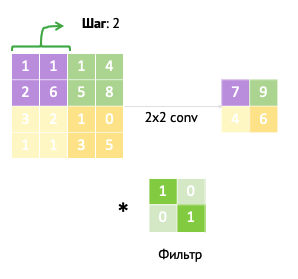

Вспомним хорошее свойство нашего классификатора: после применения свёртки мы брали максимум. Когда мы берём свёртку, мы считаем пространственную корреляцию нашего кусочка изображения с тем шаблоном, который мы хотим на нём найти. Там, где корреляция большая, мы нашли что-то похожее на наш шаблон, а затем мы брали максимум и понимали, что наша чёрточка находится под разным углом.

В нашем свёрточном слое мы нигде не использовали функцию максимума, но нужно обязательно её использовать, чтобы была инвариантность к сдвигу изображения. В этом нам поможет пулинг слой.

#### Как работает пулинг слой?

На входе есть картинка (4 × 4), и есть окно фиксированного размера (2 × 2). Если мы проходим этим окном по картинке с шагом, равным двум, то у окна есть всего четыре возможных положения. Теперь пулинг слой применяет некоторую операцию (мы возьмём максимум). В оранжевом окошке максимум пять, и поэтому на выходе получаем пять, в фиолетовом — шесть и так далее.

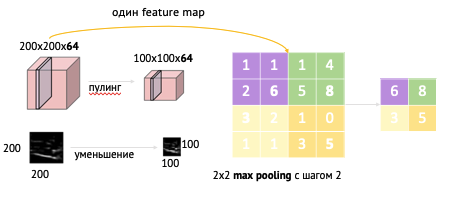

*Пулинг* слой комбинирует в себе два плюса:

* Он применяет максимум, а значит, имеет небольшую инвариантность к сдвигу.

* *Пулинг* слой обычно применяют с шагом = 2, а это значит, что наша картинка уменьшается в два раза, и поле обзора растёт быстрее.

*Пулинг* с максимумом (Max Pooling) применяется к различным feature map независимо от объёма, который мы получили: он работает на входе и на выходе с плоскими картинками и не меняет количество фильтров.

*Пулинг* с максимумом (Max Pooling) теряет детали изображения (на картинке выше показан результат свёртки 200 × 200, к которому применяют пулинг и в итоге получают картинку 100 × 100).

Чтобы встроить в нейросеть Max Pooling слой, нужно научиться прогонять через него производные, то есть нужно научиться считать производную выхода по любому входу Max Pooling, чтобы *backpropagation* смог работать и обновлять все остальные переменные.

> **Backpropagation** (обратное распространение) — это алгоритм, используемый для быстрого вычисления производных. Искусственные нейронные сети используют обратное распространение в качестве алгоритма обучения для вычисления градиентного спуска относительно весов.

#### Как считать градиент для пулинга

Возникает вопрос: как считать градиент для пулинга, если операция максимума не дифференцируема?

Очевидно, что результат макс-пулинга не изменится, если мы немного подвинем входные данные, не являющиеся максимальными. То есть при варьировании этих не максимальных элементов результат макс-пулинга не меняется, а значит, производная по этим элементам равна 0.

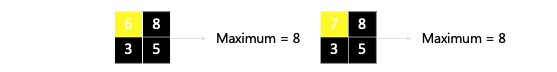

При изменении максимального элемента максимум сразу меняется, и производная по этому элементу равна 1.

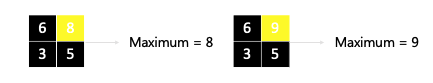

Таким образом мы можем посчитать градиент *пулинга*.

Такой подход позволяет встроить Max Pooling в наш дифференцируемый граф вычислений, при этом *backpropagation* все равно будет работать.

##### Вопросы:
1. Что такое пулинг?
2. Как работает пулинг?

**Подведём итоги**

* *Пулинг* применяется с бόльшим stride и обеспечивает более быстрое увеличение поля обзора (экспоненциальный рост против линейного).

* Взятие максимума вместо обучаемой свёртки экономит вычисления и добавляет инвариантность к сдвигу.

## Практика. Пулинг Слой

Попробуем добавить в нашу сеть пулинг слой. Мы теперь знаем, что он нужен для того, чтобы **поле обзора росло быстрее**, а также для того, чтобы **появлялась небольшая инвариантность** к сдвигу.

### Свертки в Keras

Будем использовать Fashion MNIST

In [ ]:
!pip install -q tensorflow

In [ ]:
import numpy as np  # Импорт библиотеки для работы с массивами и векторной алгеброй
from sklearn.metrics import accuracy_score  # Импорт функции для оценки точности модели
from matplotlib import pyplot as plt  # Импорт библиотеки для визуализации данных

# Настройка для отображения графиков непосредственно в блокноте (например, в Jupyter)
%matplotlib inline

import tensorflow as tf  # Импорт библиотеки TensorFlow для создания и обучения нейронных сетей
print("We're using TF", tf.__version__)  # Вывод версии TensorFlow
import tensorflow.keras as keras  # Импорт высокоуровневого API Keras для TensorFlow
import tensorflow.keras.models as M  # Импорт функционала для создания моделей в Keras
import tensorflow.keras.layers as L  # Импорт слоев для нейронных сетей в Keras
import tensorflow.keras.backend as K  # Импорт функций для низкоуровневой работы с тензорами и графами в Keras
import pandas as pd  # Импорт библиотеки для работы с данными в табличном виде (DataFrame)

We're using TF 2.17.0


### Загрузим данные

Классы:
```
0 T-shirt/top
1 Trouser
2 Pullover
3 Dress
4 Coat
5 Sandal
6 Shirt
7 Sneaker
8 Bag
9 Ankle boot
```


In [ ]:
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.fashion_mnist.load_data()

In [ ]:
print(x_train.shape)
print(x_val.shape)
print (y_train[:10])
print (y_val[:10])

(60000, 28, 28)
(10000, 28, 28)
[9 0 0 3 0 2 7 2 5 5]
[9 2 1 1 6 1 4 6 5 7]


Пример кусочка картинки:


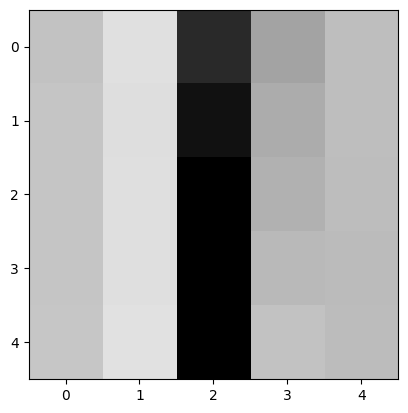

Пример картинки:


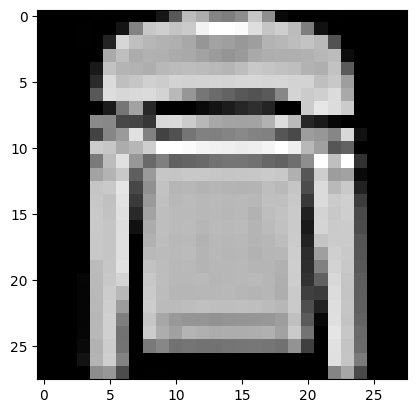

y_train [shape (60000,)] 10 примеров:
 [9 0 0 3 0 2 7 2 5 5]


In [ ]:
# Преобразование изображения для дальнейшей визуализации
# Берем 5-е изображение из набора x_train, изменяем форму и дублируем по 3-му каналу, чтобы создать изображение с 3 каналами (RGB)
x_train_image = np.tile(x_train[5, :, :].reshape((28, 28))[:, :, np.newaxis], (1, 1, 3))

# Вывод примера части изображения
print("Пример кусочка картинки:")
plt.imshow(x_train_image[15:20, 5:10], cmap="Greys")  # Отображение небольшого фрагмента изображения (с 15 по 20 строку и с 5 по 10 столбец)
plt.show()  # Показать фрагмент изображения

# Вывод всего изображения
print("Пример картинки:")
plt.imshow(x_train_image, cmap="Greys")  # Отображение всего изображения с использованием цветовой карты "Greys" для оттенков серого
plt.show()  # Показать полное изображение

# Вывод первых 10 значений из y_train и информации о форме массива y_train
print("y_train [shape %s] 10 примеров:\n" % (str(y_train.shape)), y_train[:10])  # Печать формы массива y_train и первых 10 меток (классов) для изображений

In [ ]:
# Применение one-hot кодирования к меткам классов для y_train и y_val
# Преобразуем метки в формат one-hot, где для каждого класса создается бинарный вектор длины 10
y_train_oh = keras.utils.to_categorical(y_train, 10)  # Применение one-hot кодирования к обучающим меткам
y_val_oh = keras.utils.to_categorical(y_val, 10)      # Применение one-hot кодирования к валидационным меткам

# Вывод информации о форме массива one-hot закодированных меток y_train
print(y_train_oh.shape)  # Печать формы массива y_train_oh

# Вывод первых 5 примеров закодированных меток и соответствующих исходных меток
print(y_train_oh[:5], y_train[:5])  # Печать первых 5 one-hot меток и первых 5 исходных меток

(60000, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] [9 0 0 3 0]


### Собираем модель

Будем минимизировать кросс-энтропию.

Добавим пулинг слой.

Выберем из списка слой *MaxPool2D*, так как будем делать пулинг по окошкам 2 × 2, чтобы уменьшить картинку в 2 раза.

In [ ]:
# Очистка текущего графа и освобождение ресурсов TensorFlow/Keras
K.clear_session()

# Создание новой модели с использованием изображения как входа (без вытягивания в вектор)
model = M.Sequential()  # Определяем модель как последовательную (слои будут добавляться последовательно)

# Добавление сверточного слоя (Conv2D) с 16 фильтрами 3x3, шагом 1 и сохранением размерности (padding='same')
# Входной слой принимает изображение размером 28x28 с одним каналом (черно-белое изображение)
model.add(L.Conv2D(16, kernel_size=3, strides=1, padding='same', input_shape=(28, 28, 1)))

# Добавление слоя подвыборки (MaxPool2D) для уменьшения размерности входного изображения
model.add(L.MaxPool2D())

# Добавление второго сверточного слоя (Conv2D) с 32 фильтрами 3x3
model.add(L.Conv2D(32, kernel_size=3, strides=1, padding='same'))

# Добавление второго слоя подвыборки
model.add(L.MaxPool2D())

# Добавление третьего сверточного слоя (Conv2D) с 64 фильтрами 3x3
model.add(L.Conv2D(64, kernel_size=3, strides=1, padding='same'))

# Добавление третьего слоя подвыборки
model.add(L.MaxPool2D())

# Преобразование многомерного тензора в одномерный вектор перед плотным слоем
model.add(L.Flatten())

# Добавление полносвязного (Dense) слоя с 10 нейронами и функцией активации softmax для классификации на 10 классов
model.add(L.Dense(10, activation='softmax'))

In [ ]:
# Вывод краткого описания модели
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │           5,770 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,066 (113.54 KB)

 Trainable params: 29,066 (113.54 KB)

 Non-trainable params: 0 (0.00 B)

Заметим, что слой *MaxPool2D* в два раза уменьшил размер нашей картинки, количество фильтров не изменилось.

При этом мы использовали 0 параметров, то есть нет каких-то обучаемых парамеров, здесь всегда применяется одна и та же функция максимум.

In [ ]:
model.compile(
    loss='categorical_crossentropy',  # минимизируем кросс-энтропию
    optimizer='adam',  # так будет быстрее, позже узнаем что это
    metrics=['accuracy']  # выводим процент правильных ответов
)

In [ ]:
# центрируем и нормируем, так сети будет проще учиться (позже узнаем почему :)
x_train_float = x_train.astype(float) / 255 - 0.5
x_val_float = x_val.astype(float) / 255 - 0.5

In [ ]:
# Обучение модели на тренировочных данных
model.fit(
    x_train_float[:, :, :, np.newaxis],  # Тренировочные данные. Добавляем дополнительное измерение (канал) для соответствия входному формату (28x28x1).
    y_train_oh,  # One-hot закодированные метки классов для тренировочных данных.
    batch_size=32,  # Размер мини-выборки (batch size). Модель обновляет свои параметры после каждого мини-пакета из 32 изображений.
    epochs=5,  # Количество эпох — полный цикл обучения на всех тренировочных данных. Модель обучится за 5 эпох.
    validation_data=(x_val_float[:, :, :, np.newaxis], y_val_oh)  # Валидационные данные, на которых модель будет проверяться после каждой эпохи.
)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7733 - loss: 0.6406 - val_accuracy: 0.8619 - val_loss: 0.3813
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8811 - loss: 0.3354 - val_accuracy: 0.8779 - val_loss: 0.3430
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8966 - loss: 0.2885 - val_accuracy: 0.8936 - val_loss: 0.2940
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9081 - loss: 0.2527 - val_accuracy: 0.8962 - val_loss: 0.2879
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9170 - loss: 0.2285 - val_accuracy: 0.8927 - val_loss: 0.2921


### Первая свёрточная сеть

Теперь мы готовы собрать нашу первую свёрточную сеть.

Для примера рассмотрим архитектуру *LeNet*, придуманную в 1998 году. Она применялась для *MNIST* — задачи распознавания рукописных цифр.

На вход принималась чёрно-белая картинка размера 32 × 32 × 1. Сначала предлагается применить свёртку с фильтром размером 5 × 5 и обучить шесть таких фильтров, чтобы на выходе получить объём 28 × 28 × 6 (32 превратилось в 28 потому, что мы не использовали *padding*, то есть использовали только те положения, куда фильтр помещается в нашу картинку без всякой добавки). Дальше предлагается использовать *пулинг* слой, чтобы уменьшить картинку в 2 раза, таким образом получив размеры 14 × 14 × 6.

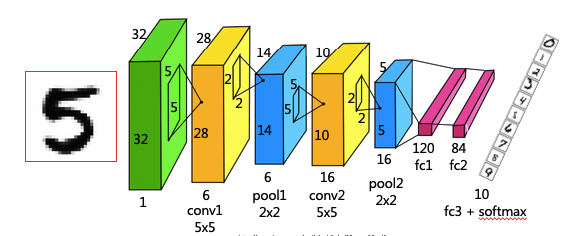

Количество фильтров при этом не поменяется, так как пулинг работает с каждой *feature map* независимо.

Потом применяем ещё один свёрточный слой с фильтром 5 × 5, чтобы увеличить поле обзора, и получаем размеры 10 × 10 × 16. Фильтров, которые обучаются, становится уже больше. Это делается для того, чтобы не терять информацию.

Вновь используем пулинг слой, который сделает нашу картинку размером 5 × 5 × 16. Полученный объём предлагается вытянуть в вектор и к этому вектору применить 2 полносвязных слоя, то есть предполагается, что в этом последнем *пулинг* слое в 16 признаках уже закодирована нужная информация, которая поможет нам воссоздать цифру.

После применения двух полносвязных слоёв нужен выходной слой, на котором будет десять выходов, так как у нас десять цифр, и будет применена функция *softmax*, которая превратит любые выходы в правильное распределение вероятностей.

Если взять 60 000 примеров, где у нас есть картинка на входе и для неё известен класс, собрать эту архитектуру и оставить backpropagation на пару минут, то он выучит все веса на всех слоях, которые решают эту задачу практически идеально.

#### Как работает функция softmax?

Допустим, мы посчитали десять выходов. Каждый из них заменим на экспоненту в степени этого выхода и пронормируем все полученные экспоненты, чтобы в сумме они давали 1. Так как экспонента неотрицательна, а их сумма равна 1, то получим правильное распределение вероятностей.

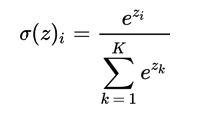

#### Кросс-энтропия

Чтобы запустить *backpropagation*, нужно знать, какую функцию потерь использовать. Для классификации на K классов обычно используют функцию потерь, которую называют **кросс-энтропия** (cross-entropy).

Для каждого примера мы идём по всем возможным классам и, если пример принадлежит этому классу, то мы в потери записываем логарифм со знаком «минус» от предсказанной вероятности этого класса.

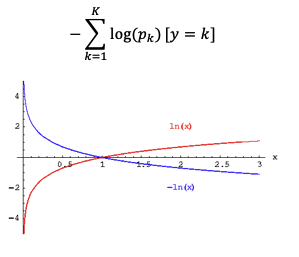

По графику функции -ln(х) видно, что если аргумент этой функции близок к 1, то потери близки к 0, а если аргумент близок к 0, то потери уходят в бесконечность. Это означает, что в потерях на правильном классе хочется видеть вероятность как можно более близкую к 1. Это и будет решать нашу задачу  классификации.

Если обучить нашу нейросеть и посмотреть на каждом слое изображения, на какие кусочки реагируют (имеют большую активацию) наши нейроны, то заметим, что на первом слое нейроны реагируют на простые паттерны на изображении (например, они могут находить перепады яркости под разными углами). Второй свёрточный слой уже может распознавать что-то более сложное (например, кусочек глаза) и так далее. Таким образом нейросеть учит иерархические шаблоны. Первые признаки на первом сверточном слое - низкоуровневые (изменение яркости под углом), на втором слое они чуть более высокоуровневые, так как из информации о яркости под разным углом, можно собрать более сложный шаблон.

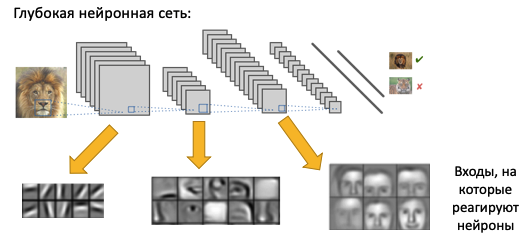

Если смотреть на более глубокие сверточные слои, то на каких-то из них нейроны будут реагировать на целое лицо на изображении.

Плюсы обучения сверточный нейросетей в том, что все эти признаки, веса всех промежуточных фильтров будут найдены автоматически при помощи backpropagation.

### Практика. Первая свёрточная сеть

Разберем подробнее код, рассмотренный ранее на основе Fashion MNIST:

После добавления всех необходимых сверточных слоев и пулинг-слоя для уменьшения картинки, в результате мы получаем картинку размера 3х3х64. Далее вытягиваем все имеющиеся нейроны в один плоский вектор. Поверх этого плоского вектора мы можем наслоить пару полносвязных слоёв  и решить нашу задачу классификации.

Для того чтобы вытянуть картинку в вектор, добавляем слой **Flatten**.

На выходе получим результат: flatten_1 (Flatten) (None, 576) 0

576 — это ровно та размерность, которая у нас была: 3 × 3 × 64 = 576.

Теперь нам понятно, как работать с этим вектором. К нему можно применить полносвязные слои и получить новый ветор на выходе. Применим плотный слой , у которого будет десять выходов (так как у нас десять классов) с функцией активации softmax, поскольку она даёт распределение вероятностей.

На выходе получим сеть с 30 000 параметров, а 576 нейронов превратились в десять.




In [ ]:
# Очистка текущего графа и освобождение ресурсов TensorFlow/Keras
K.clear_session()

# Создание новой модели с использованием изображения как входа (без вытягивания в вектор)
model = M.Sequential()  # Определяем модель как последовательную (слои будут добавляться последовательно)

# Добавление сверточного слоя (Conv2D) с 16 фильтрами 3x3, шагом 1 и сохранением размерности (padding='same')
# Входной слой принимает изображение размером 28x28 с одним каналом (черно-белое изображение)
model.add(L.Conv2D(16, kernel_size=3, strides=1, padding='same', input_shape=(28, 28, 1)))

# Добавление слоя подвыборки (MaxPool2D) для уменьшения размерности входного изображения
model.add(L.MaxPool2D())

# Добавление второго сверточного слоя (Conv2D) с 32 фильтрами 3x3
model.add(L.Conv2D(32, kernel_size=3, strides=1, padding='same'))

# Добавление второго слоя подвыборки
model.add(L.MaxPool2D())

# Добавление третьего сверточного слоя (Conv2D) с 64 фильтрами 3x3
model.add(L.Conv2D(64, kernel_size=3, strides=1, padding='same'))

# Добавление третьего слоя подвыборки
model.add(L.MaxPool2D())

# Преобразование многомерного тензора в одномерный вектор перед плотным слоем
model.add(L.Flatten())

# Добавление полносвязного (Dense) слоя с 10 нейронами и функцией активации softmax для классификации на 10 классов
model.add(L.Dense(10, activation='softmax'))

In [ ]:
# Вывод краткого описания модели
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │           5,770 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,066 (113.54 KB)

 Trainable params: 29,066 (113.54 KB)

 Non-trainable params: 0 (0.00 B)

### Современные архитектуры

Посмотрим, как устроены современные архитектуры свёрточных сетей.

Вспомним про задачу *ImageNet*. Люди за много лет насобирали более миллиона изображений, которые размечены на 1 000 классов. Классы довольно сложные (например, разные породы собак и кошек). Для неподготовленного человека разделить эти изображения на классы достаточно сложно.

В 2012 году решению этой задачи обучили огромную **нейросеть AlexNet**.

Устроена она была так: у нас есть несколько свёрточных слоев с *макс-пулингом* между ними, и мы используем свёртки 11 × 11, 5 × 5 и 3 × 3.

В этой сети было 60 миллионов параметров, и это была беспрецедентная сеть на тот момент.

Про аугментацию данных — один из трюков нейросети AlexNet — можем поговорить уже сейчас.

В нейросети было 60 миллионов параметров, которые нужно оценить по миллиону изображений. На самом деле картинок слишком мало, чтобы оценить столько параметров. Попробуем слегка видоизменить картинки (повернуть, отразить, растянуть, поменять резкость) и тогда наши данные для обучения увеличатся. Все эти манипуляции с картинками и называются **аугментацией данных**.

Стоит отметить, что добавлять сдвиги при аугментации данных бесполезно.

Можно было бы предположить, что сдвиги помогут нам научиться искать котов на разных положениях на картинке, но нам это не нужно, если у нас есть макс-пулинг слой, ведь достаточно просто сделать архитектуру таким образом, чтобы где-то близко к выходному слою мы взяли максимум.

Другой пример архитектуры — **VGG**, предложенная в 2015 году (спустя 3 года после AlexNet). Видеокарты к тому времени стали мощнее, и новая сеть содержала 138 миллионов параметров. Здесь уже не использовали дорогие и тяжёлые свёртки размера 11 × 11, а обошлись большим числом свёрток размером 3 × 3. В остальном по принципу нейросеть очень похожа на AlexNet.

## Inception V3

Теперь познакомимся с архитектурой **Inception V3**, предложенной также в 2015 году и отличающейся от *AlexNet*. В этой сети значительно меньше параметров (всего 25 миллионов). Эта сеть состоит из оригинальных inception-блоков (их рассмотрим чуть позже) и дополнительных трюков, таких как батч-нормализация, аугментация и RMSProp (алгоритм оптимизации).

### Как устроен inception-блок?

Первое, с чем нам нужно познакомиться, — свёртка 1 × 1.

Пусть у нас есть входной объём (светло-оранжевый на картинке). И если у нас есть окошко 1 × 1, это означает, что мы берём глубокий пиксель из
С
 объёма и хотим получить другой пиксель другой глубины.

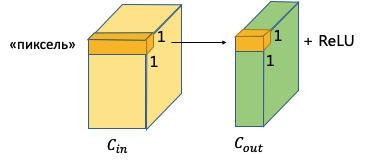

То есть мы будем искать новые пиксели как линейные комбинации входных. Такое линейное преобразование очень похоже на уменьшение размерности.

Объясняя простым языком, мы даём нейросети возможность обучать много фильтров, а затем похожие фильтры схлопываются в один линейным преобразованием.

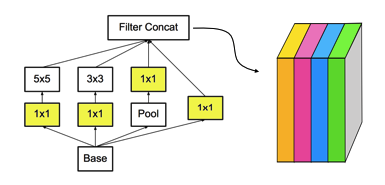

### Как устроен inception-блок внутри?

На входе нам поступает некоторый объём, и к нему применяют четыре ветки вычисления:

1. Первая ветка применяет свёртку 1 × 1, чтобы уменьшить глубину этого объёма. Дальше применяется свёртка 5 × 5 с таким padding, чтобы на выходе высота и ширина изображения остались неизменными.

2. На второй ветке применяем свёртку 1 × 1, а затем 3 × 3.

3. На третьей ветке применяем пулинг с шагом 1, а затем свёртку 1 × 1.

4. Четвёртая ветка просто делает свёртку 1 × 1.

Отметим, что можно так подобрать padding и stride, что измерения W и H выходных объёмов всех веток будут одинаковыми, а глубина будет различаться. Это означает, что их можно будет склеить по глубине. В итоге получим один большой объём.

Можно заменить свёртки 5 × 5 двумя свёртками 3 × 3:

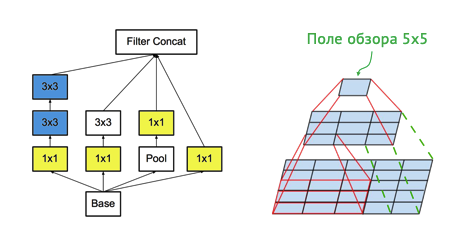

Количество параметров, необходимых для такой операции, станет меньше.

### Сепарабельные фильтры

Существует фильтр размытия по Гауссу — гауссиан, то есть мы возьмём кусочек изображения, взвесим все пиксели с весами, которые даёт нам гауссиан, и получим размытие по Гауссу. Это размытие можно «дёшево» сделать одномерными свёртками.

Например, пусть у нас есть синий пиксель. Сначала сделаем размытие одномерным гауссовским ядром по горизонтали:

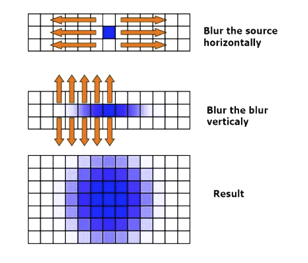

К этому результату можно применить свёртку по вертикали, и мы получим такой же результат, как если бы мы применяли двумерную свёртку к нашему пикселю. Если посчитать количество операций при размытии по горизонтали, а затем по вертикали, то количество операций окажется в разы меньше.

Такие фильтры, которые позволяют заменить себя на последовательность одномерных, называются **сепарабельными**.

Дадим нейросети возможность учить такие фильтры, заменим в нашем inception-блоке свёртки 3 × 3 на сепарабельные свёртки 1 × 3 и 3 × 1.

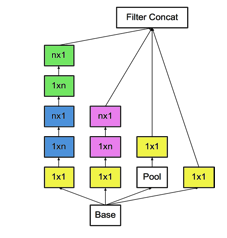

Таким образом, мы придумали очень эффективный inception-блок, который использует мало параметров и даёт лучшее качество, чем набор свёрток 3 × 3.